#### model preprocessing and import

In [1]:
from transformers import AutoModelForAudioClassification,AutoTokenizer,BatchFeature, pipeline
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2ForSequenceClassification,Wav2Vec2Tokenizer,Wav2Vec2ForCTC
from datasets import load_dataset
import librosa,os,time,torch
import soundfile as sf
from IPython.display import Audio,display,clear_output

import cv2
import numpy as np

In [2]:
# from transformers import AutoTokenizer, AutoModelForAudioClassification
  
# tokenizer = AutoTokenizer.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")

# model = AutoModelForAudioClassification.from_pretrained("ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition")

#### loading ASR model

In [3]:
  
feature_extractor_asr = Wav2Vec2FeatureExtractor.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english")
tokenizer_asr = AutoTokenizer.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english")

model_asr = Wav2Vec2ForCTC.from_pretrained("jonatasgrosman/wav2vec2-large-xlsr-53-english")

classifier_asr = pipeline('automatic-speech-recognition',model=model_asr,feature_extractor=feature_extractor_asr,tokenizer=tokenizer_asr,device=0)

/home/prateek/.virtualenvs/pytorch/lib/python3.8/site-packages/transformers/configuration_utils.py:346: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


#### loading emotion analysis model

In [4]:
##examples https://huggingface.co/jonatasgrosman/wav2vec2-large-xlsr-53-english
model_path = "ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition"
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(model_path)

model = Wav2Vec2ForSequenceClassification.from_pretrained(model_path)
model_sr = 16000
classifier = pipeline(task="audio-classification",model=model,feature_extractor=feature_extractor,device =0)


Some weights of the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition were not used when initializing Wav2Vec2ForSequenceClassification: ['classifier.output.weight', 'classifier.output.bias', 'classifier.dense.weight', 'classifier.dense.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at ehcalabres/wav2vec2-lg-xlsr-en-speech-emotion-recognition and are newly initialized: ['projector.bias', 'classifier.weight', 'c

##### sample

In [4]:

speech, rate = librosa.load("/home/prateek/hdd/ubuntu/data/ravdess/actors/Actor_03/03-01-02-01-02-01-03.wav")

classifier(speech)

[{'score': 0.14632642269134521, 'label': 'neutral'},
 {'score': 0.13282646238803864, 'label': 'happy'},
 {'score': 0.12839139997959137, 'label': 'calm'},
 {'score': 0.12732456624507904, 'label': 'sad'},
 {'score': 0.1262546181678772, 'label': 'angry'}]

#### support functions

In [22]:
#Resampling function
def resample(file_path, sr): 
    print("\nResampling of " + os.path.basename(file_path) + " in progress")
    audio, sr = librosa.load(file_path, sr=sr)                           #File load and resampling
    length = librosa.get_duration(audio, sr)                        #File lenght
    resampled_folder = os.path.join(os.path.dirname(file_path),"resampled")
    os.makedirs(resampled_folder,exist_ok=True)
    sf.write(os.path.join(resampled_folder,os.path.basename(file_path)), audio, sr)        #(resampled_folder + file, audio, sr)
    print(os.path.basename(file_path) + " was resampled to " + str(sr) + "kHz")

In [23]:
resample("../../../data/sample_audio/customer_complaint.wav",16000) ### sampling rate of output


Resampling of customer_complaint.wav in progress
customer_complaint.wav was resampled to 16000kHz


In [25]:
def draw_indicator(img, percentage,text=""):

    def percentage_to_color(p):
        return 0,  255 - (255 * p),255*p

    # config
    img_h,img_w = img.shape[:2]
    levels = 10
    indicator_width = 80
    indicator_height = 220
    level_width = indicator_width - 20
    level_height = int((indicator_height - 20) / levels - 5)
    # draw
    img_levels = int(percentage * levels)
    cv2.rectangle(img, (10, img.shape[0] - (indicator_height + 10)), (10 + indicator_width, img.shape[0] - 10), (0, 0, 0), cv2.FILLED)
    cv2.putText(img,text,(150,img_h-20),cv2.FONT_HERSHEY_SIMPLEX,.5,(150,255,255),0)
    for i in range(img_levels):
        level_y_b = int(img.shape[0] - (20 + i * (level_height + 5)))
        cv2.rectangle(img, (20, level_y_b - level_height), (20 + level_width, level_y_b), percentage_to_color(i / levels), cv2.FILLED)

#### Prediction loop

In [31]:
## audio batching
##A sample is the smallest usable quantum of digital audio. The term frame isn't formally defined in pure audio terms, but is often used 
# in relation to video that may accompany an audio track. In that context a frame is the quantity of audio samples taken during a video 
# frame interval. If there are 30 video frames per second and 48000 audio samples per second, you could say that there are 48000 / 30 = 1600 
# samples per frame, or that an "audio frame" contains 1600 samples, but there literally is no audio frame, it's just a convention for
# talking about audio with respect to a video frame rate.

file_path = "/home/prateek/hdd/ubuntu/data/sample_audio/resampled/Steve Jobs' 2005 Stanford Commencement Address.wav"
file_path = "/home/prateek/Desktop/customer_complaint.wav"
sr = librosa.get_samplerate(file_path)
frame_length = 16000 # number of samples in a frame
hop_length = 16000 # number of sample that will be hopped in a frame, it will decide overlap
block_length = 4 # number of frames in block/batch 

# Stream the data, working on 128 frames at a time
stream = librosa.stream(file_path,
                        block_length=block_length,
                        frame_length=frame_length,
                        hop_length=hop_length)

    
    
    
    
    

# test code
# img = cv2.imread('a.jpg')
# cap = cv2.VideoCapture(0)
# scale_mapping = {"sad":.25,"disgust":.5,"fear":.75,"angry":1}

### creating chunks
files = []
for f in stream:
    files.append(f)
stream.close()

### direct load----------------------------
audio,_ = librosa.load(file_path,sr=model_sr)
files = []
for i in range(0,len(audio),model_sr*block_length):
    files.append(audio[i:i+model_sr*block_length])


##############-----------------------------






frame = cv2.imread("emotion_meter.jpg")
frame1 = frame.copy()

cv2.namedWindow("emotion-meter", cv2.WINDOW_NORMAL)

display(Audio(file_path,rate=model_sr,autoplay=True))
t1 = time.time()
idx = 0
while True:
    
    # clear_output(wait=True)
    # ret,frame = cap.read() 
    if idx>=len(files):
        break
    play_time = time.time()-t1
    if int(play_time)>(idx+1)*block_length and play_time>0:
        # f  = next(stream)
        # display(Audio(f,autoplay=True,rate=16000))
        # print(play_time,idx)
        res = classifier(files[idx])
        res_asr = classifier_asr(files[idx])
        text = res_asr["text"]
        
        idx+=1

        op_label = res[0]["label"]
        # print(res)
        if op_label=="sad":
            percent = .4
        elif op_label=="disgust":
            percent = .6
        elif op_label=="fearful":
            percent = .8
        elif op_label=="angry":
            percent = 1
        else :
            percent = .25

        # percent = np.random.rand()
        frame1 = frame.copy()
        print(op_label,"-->",text)
        draw_indicator(frame1, percent,text)
    cv2.imshow("emotion-meter", frame1)
    k = cv2.waitKey(1)
    if k==ord('q'):
        break
cv2.destroyAllWindows()

# cap.release()

calm --> HY THIS IS JACEN HOW CAN I HELP YOU THIS AFTERNOON
surprised --> ELL ME I'M LOOKING AT MY NEW STATEMENT AND I SEE THAT YOU PEOPLE HAVE CHAR
disgust --> ARGED AGAIN FOR THE SAME FEES I'VE BEEN CALLING ABOUT FOR MONTHS NOWI'M SICK
surprised --> ENTARDA BEING TOLD THAT IT'S HANDLED WHEN PRETTY CLEARLY IT'S NOT
disgust --> OSORRY TO HEAR THATLET ME TAKE A LOOK AT YOUR ACCOUNT AND FIND OUT WHAT'S GOING ON
calm --> CAN YOU REMIND ME WHEN THEY STARTED FIND THE FIRST FEE
calm --> S SHOWED UP THREE MONTHS AGO IF YOU CAN'T FIX THIS I'M GOING TO CLOSE THE ACCOUNT
surprised --> I COMPLETELY UNDERSTAND YOUR FRUSTRATIONLET MES
disgust --> E WHAT I CAN DO TO HELP GET THIS TAKING CARE FFOR YOU RIGHT NOWI'M GLAD I WAS ABLE TO GET THAT ISSUE TACE
calm --> N CARE OFIT MAY TAKE UP THO TWENTY-FOUR HOURS FOR YOUR COUNT TO SHOW THE CHANGES BUT YOU SHOULDN'T SEE
disgust --> ANY MORE OF THESE FEES IN THE FUTURE THANKS FOR WORKING WITH ME TO FIGURE IT OUT


## ---------------------------------------------------------------------------------------------------------------------------

### Audio related use case
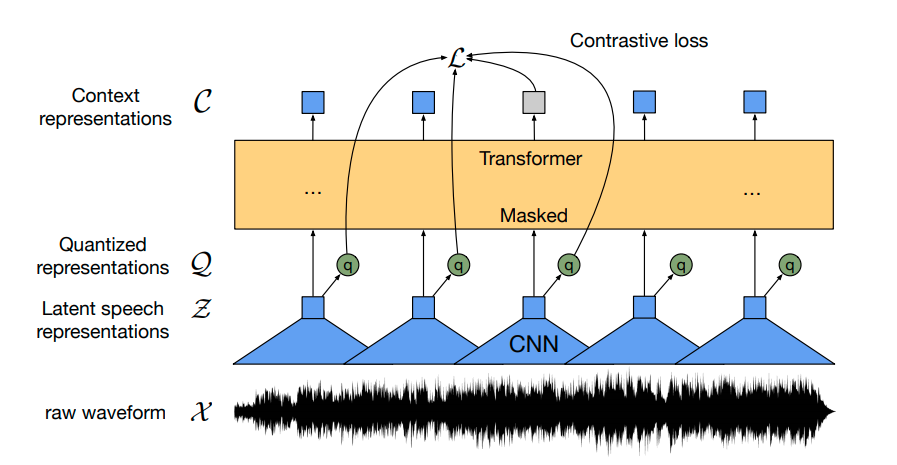

- Diarization
- speaker Identification
- sentiment
- audio classification
- ASR
- Sentiment analysis


## ---------------------------------------------------------------------------------------------------------------------------

#### LSSED model testing

In [2]:
from pyconvresnet import PyConvBlock,PyConvResNet

In [ ]:
PyConvResNet

In [6]:
model = PyConvResNet(PyConvBlock, [3, 8, 36, 3])


In [7]:
model = model.load_state_dict(torch.load("../../../models/lassed_models/ckpt_c4_pyres101.pth"))


/home/prateek/.virtualenvs/pytorch/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/prateek/.virtualenvs/pytorch/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/prateek/.virtualenvs/pytorch/lib/python3.8/site-packages/torch/serialization.py:656: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can

AttributeError: 'DataParallel' object has no attribute 'copy'

In [72]:
classifier_asr(f)

{'text': 'ND FOR THE INCONVENIENCETHANKS JASON I APPRECIATE YOUR HELP'}